# Study for external time precision in Energy resolution 



 1. Simulated files (10000p for surface creation & 2000 test files (or the same surface files))
 2. Reconstruct "surface" files @ different lags (-2,-1.0,1,2) 
    reconstruction out-of-place and knowledge of arrival time -> $\Delta$t, Pheight, Einput
 3. Surface creation (PH vs TimeOffset vs InputEnergy) -> polyfit -> coefficients
 4. Calibration of "test" files: Ecorr = SFC(PH,TimeOffset)
     reconstruction in-place and UNknowledge of arrival time
 5. Plot of residuals of surface data corrected by surface
 
 **Note**
 
 *i* -> energy
 
 *j* -> time lag
 
 *k* -> pulse
 
 For surface calibration, evt files are (usually) previously created with runCompareACDC.sh and calibrated here (test files are those to be calibrated and calibration files are those used for the gainScale curve also).

In [10]:
# ----IMPORT MODULES --------------
from __future__ import print_function
from __future__ import division
from multiprocessing import Pool, cpu_count
from itertools import repeat
from subprocess import check_call, check_output,STDOUT
from cycler import cycler
from astropy.io import fits
from scipy.stats import norm
from statistics import mean
import math
import sys, os
import shutil, tempfile, shlex
import re
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy.polynomial import Polynomial
import auxpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.colors as mcolors

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"


# Define auxiliary functions

In [12]:
def fit_2D_gain_scale(ph_values,phase_values,energy_list,degx=6,degy=6,show=False):
    '''Fits a 2D gain scale giving the energy as a function of ph and phase (by PP)
    
    Arguments:
        - ph_values: 2D array of the measured PH values
        - phase_values: 2D array of the measured phase values
        - energy_list: 1D array of the simulated energies
        - deg: degree of the polynom to fit (in both X and Y)
        - show: option to plot the results
    '''
    ph_values = np.array(ph_values)
    phase_values = np.array(phase_values)
    energies = np.array([energy_list for _ in range(len(ph_values[0]))]).transpose()
    poly_coeffs = polyfit2d(ph_values, phase_values, energies, [degx,degy])
    return poly_coeffs

def polyfit2d(x, y, f, deg):
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = np.polynomial.polynomial.polyvander2d(x, y, deg)
    #print(vander.size)
    #print(vander)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

def find_nearest_idx(array,value):

    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        idx -= 1
    return idx

# Define variables 

In [13]:
#      Simulation options to calculate jitter correction
# ========================================================
dcmt = 100 # decimation factor - NOT USED if BBFB
bbfb = "bbfb" # "" for not_bbfb or "bbfb" for dobbfb in xifusim
smprt = "" # "" or "samprate2" or "samprate4"
Lc = "" # "" for critical damping; otherwise '0.35Lc', '0.5Lc' or '0.7Lc'
npulsesLib = 20000 # number of pulses for libraries
npulsesGain = 10000 # number of pulses for gainScale
preBufferSize = 1000 # old prebuffer (samples before the time of a trigger-pulse to start a record)
Fitting35=3
domain="T"  # or "F"
recStr="OPTFILT" # or "I2R", "I2RNOL", "I2RFITTED", "OPTFILTNM"
pulseLength=8192 # or shorter lengths
ofLength=8192 # for 0-padding or shorter filters otherwise

noiseForSFC = "" # "" for noisy files and "_nonoise" for nonoise files 
if noiseForSFC == "_nonoise": 
    SFCpulses = 1000 # number of pulses for curve/surface creation (nonoise)
    noiseStr="NO NOISE"
    #NNexpos=262 # for the nonoise pulses
if noiseForSFC == "":
    SFCpulses = 10000 # number of pulses for curve/surface creation (noisy)
    noiseStr="NOISY"
    SFCexpos=2640 # for the SFC pulses
    
#TSpulses = 2000 # number of pulses for test of FWHM (noisy)
TSpulses = 10000 # number of pulses for test of FWHM (noisy) if using SFCpulses
#TSexpos=525 # for the 2000 Test pulses
TSexpos=SFCexpos # for the Test pulses= SFC pulses

eurecaDir = "/dataj6/ceballos/INSTRUMEN/EURECA"
sixteDir = eurecaDir + "/testHarness/simulations/SIXTE"
sixteInst = os.environ["SIXTE"] + "/share/sixte/instruments/athena-xifu/"
xmlfile = (sixteInst +
            "/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml")
pairsDir = eurecaDir + "/ERESOL/PAIRS"
impDir = pairsDir + "/PIXIMPACT"
ereDir = pairsDir + "/eresolLPA75um"
gainDir = ereDir + "/gainScale"
tesDir = pairsDir + "/xifusimLPA75um"
coeffsfile = ereDir + "/coeffs_polyfit_externalTime_nico.dat"
# degree of polynomial surface
degPH=5
degTI=5
surfaceFile = (ereDir + "/coeffs_poly2Dfit_externalTime_pL" + str(pulseLength) + "_" + recStr + str(ofLength) +
               "_degPH" + str(degPH) + "_degTI" + str(degTI) + "_nico.dat")
#eners_keV = (0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8)
eners_keV = (1, 2, 3, 4, 5, 6, 7)
#eners_keV = (8,)
libEnergies = (6,) # optimal filter in library
#test_keV = (0.2,0.5,1,2,3,4,5,6,7,8)
test_keV = (1,2,3,4,5,6,7)
#test_keV = (7,)
#timeErrors = [0, 0.01e-6, 0.02e-6, 0.05e-6, 0.07e-6, 0.1e-6, 0.15e-6,
#              0.2e-6, 0.4e-6, 0.6e-6, 0.8e-6, 1.0e-6, 1.2e-6, 1.4e-6,
#              1.6e-6, 1.8e-6, 2.0e-6, 2.2e-6, 2.4e-6, 2.6e-6, 2.8e-6, 3e-6]
timeErrors_usec = [0, 0.01, 0.02, 0.05, 0.07, 0.1, 0.15,
              0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4,
              1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3] #usec

timeErrorsStr = [str(item) + "e-6" for item in timeErrors_usec]
timeErrorsStr[0] = '0'
timeErrors = [i * 1e-6 for i in timeErrors_usec]

lagsornot = 0 # Only a reconstruction (not try to find a parabola)
errorT = ("-2","-1","0","1","2") # displacement (samples) for reconstruction (to make surface)
indexT0 = errorT.index("0")
numlags = len(errorT) - 1

# samprate
#smprt = "samprate2"
smprt = ""
smprtStr = ""
if smprt == "samprate2":
    #eners_keV = (1, 2, 3, 4, 5, 6, 7,8)
    #test_keV = (1,2,3,4,5,6,7,8)   
    smprtStr = "_samprate2"
    samprate = 78125. # Hz
    nSamples = 4096
    largeFilter = 4096
    pulseLength=4096
    nSgms = 4 #6
    samplesUp = 2 #2
    samplesDown = 4 #3 
    singleSeparation = 20000
    SFCexpos=2715 # for the SFC pulses
    TSexpos = 543 
    #NNexpos=269 # for the nonoise pulses
elif smprt == "samprate4":
    smprtStr = "_samprate4"
    samprate = 39062.5 # Hz
    nSamples = 2048
    largeFilter = 2048
    pulseLength=2048
    nSgms = 4 #6
    samplesUp = 2 #2
    samplesDown = 4 #3 
    singleSeparation = 10000
else:
    samprate = 156250. # Hz
    nSamples = 8192
    largeFilter = 8192
    nSgms = 3.5
    samplesUp = 3
    samplesDown = 4
    singleSeparation = 40000
    
triggerSizeTC = 1000 + 2*singleSeparation + 1000
triggerSizeTS = preBufferSize + pulseLength + 1000
triggerTS3val = triggerSizeTS - preBufferSize

# jitter
jitterStr = ""
jitterStrPix = ""
offset = 0
#bbfb
bbfbStr = ""
if bbfb == "bbfb":
    bbfbStr = "_bbfb"
    jitterStr = "_jitter"
    jitterStrPix = "_jitter"
elif dcmt > 1 :
    jitterStr = "_jitter_dcmt" + str(dcmt)
    jitterStrPix = "_jitter"
    offset = -1
# Lcrit
LcStr = ""
if not Lc == "":
    LcStr = "_" + Lc + "Lc"

# define optimized colors for offset plots
cols = [(165,0,38),(215,48,39),(244,109,67),(253,174,97),(254,224,144),(224,243,248),(171,217,233),(116,173,209),
        (69,117,180),(49,54,149)]
reversed_cols = cols[::-1]
for i in range(0,len(cols)):
        cols[i] = tuple(round((x/255.),2) for x in reversed_cols[i])
        # print("Color=", cols[i])



# ... and filenames

In [26]:
# a) Filenames for surface fitting and dependency curves 
# ========================================================
impFs = list()
#imp0Fs = list()
#evtFs = list()
evtFs = [[None] * len(errorT) for i in range(len(eners_keV))]
evtFs_calib = [[None] * len(errorT) for i in range(len(eners_keV))]
#evtFs_calib = list()
tesFs = list()
libfile = (sixteDir + "/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL" + str(pulseLength) + "_" +
           str(npulsesLib) + "p" + smprtStr + jitterStr + noiseForSFC + bbfbStr + LcStr + ".fits")

for i in range(0,len(eners_keV)):    
    file = (impDir + "/sep" + str(singleSeparation) + "sam_" + str(SFCexpos) + "s_" + str(eners_keV[i]) + "keV" +
            smprtStr + jitterStr + "_trSz" + str(triggerSizeTC) + ".piximpact")
    #print(file)
    impFs.append(file)
    
    file = (tesDir + "/sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_" + str(eners_keV[i]) +
            "keV" + smprtStr + jitterStr + noiseForSFC + bbfbStr + LcStr + ".fits")
    #print(file)
    tesFs.append(file)
    
    #print("\nSurface fitting files for ",eners_keV[i],"keV:\n")
    for j in range(0,len(errorT)):    
        file = (gainDir + "/events_sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_SIRENA" +
                str(nSamples)+ "_pL" + str(pulseLength) + "_" + str(eners_keV[i]) +
                "keV_STC_" + domain+ "_fixedlib6OF_" + recStr + str(ofLength) + smprtStr + jitterStr +
                noiseForSFC + bbfbStr + LcStr + "_NOlags_errorT" + errorT[j] +".fits")
        #print(file)
        evtFs[i][j] = file
        
        file = (gainDir + "/events_sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_SIRENA" +
                str(nSamples)+ "_pL" + str(pulseLength) + "_" + str(eners_keV[i]) +
                "keV_STC_" + domain+ "_fixedlib6OF_" + recStr + str(ofLength) + smprtStr + jitterStr +
                noiseForSFC + bbfbStr + LcStr + "_NOlags_errorT" + errorT[j] +"_HR.calib")
        #print(file)
        evtFs_calib[i][j] = file

# a) Filenames for test (noisy)
# =============================
test_impFs = list()
test_tesFs = list()
test_evtFs = list()

tnpulsesLib = 20000
    
tlibfile = (sixteDir + "/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL" + str(pulseLength) + "_" +
           str(tnpulsesLib) + "p" + smprtStr + jitterStr + bbfbStr + LcStr + ".fits")

print("\nTest files:\n")
for i in range(len(test_keV)):
    file = (impDir + "/sep" + str(singleSeparation) + "sam_" + str(TSexpos) + "s_" + str(test_keV[i]) + "keV" +
            smprtStr + jitterStrPix + "_trSz" + str(triggerSizeTC) + ".piximpact")
    print(file)
    test_impFs.append(file)
    
    file = (tesDir + "/sep" + str(singleSeparation) + "sam_" + str(TSpulses) + "p_" +
            str(test_keV[i]) + "keV" + smprtStr + jitterStr + bbfbStr + LcStr + ".fits")
    print(file)
    test_tesFs.append(file)
    
    file = (ereDir + "/events_sep" + str(singleSeparation) + "sam_" + str(TSpulses) +
            "p_SIRENA" + str(nSamples)+ "_pL" + str(pulseLength) + "_" + str(test_keV[i]) +
            "keV_STC_" + domain + "_fixedlib6OF_" + recStr + str(pulseLength) + smprtStr + jitterStr +
            bbfbStr + LcStr + "_FT" + str(Fitting35) + "_NOlags" + ".fits")
    print(file)
    test_evtFs.append(file)



Test files:

/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/PIXIMPACT/sep40000sam_2640s_1keV_jitter_trSz82000.piximpact
/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/xifusimLPA75um/sep40000sam_10000p_1keV_jitter_bbfb.fits
/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep40000sam_10000p_SIRENA8192_pL8192_1keV_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb_FT3_NOlags.fits
/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/PIXIMPACT/sep40000sam_2640s_2keV_jitter_trSz82000.piximpact
/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/xifusimLPA75um/sep40000sam_10000p_2keV_jitter_bbfb.fits
/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep40000sam_10000p_SIRENA8192_pL8192_2keV_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb_FT3_NOlags.fits
/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/PIXIMPACT/sep40000sam_2640s_3keV_jitter_trSz82000.piximpact
/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/xifusimLPA75um/sep40000sam_10000p_3keV_jitter_bbfb.fits
/dataj6/ceballos/INS

# Data files for surface fitting (NOISY) - those from gainscale

PIXIMPACT -> XIFUSIM (serpens)-> SIRENA(STC) -> CALIBRATED


In [5]:
# RECONSTRUCT surface files
run=0
# 3) Run SIRENA (AD,STC)
# =======================
if run:
    print("Reconstructing SURFACE (external Time)",SFCpulses, "single files with lib:", libfile)
    print("jitter=",jitterStr,"bbfb=",bbfb,"samprate=",smprtStr, "Lc=", LcStr)
    #sys.exit()
    for i in range(0,len(eners_keV)):
        for j in range(0,len(errorT)):
            #comm = ("tesreconstruction Recordfile=" + tesFs[i] + " TesEventFile=" + evtFs[len(errorT)*i+j] + " Rcmethod=SIRENA" + 
            comm = ("tesreconstruction Recordfile=" + tesFs[i] + " TesEventFile=" + evtFs[i][j] + " Rcmethod=SIRENA" + 
                    " PulseLength="+ str(pulseLength) + " LibraryFile=" + libfile +
                    " samplesUp=" + str(samplesUp) + " nSgms=" + str(nSgms) + " samplesDown=" + str(samplesDown) + 
                    " opmode=1 OFLib=yes FilterDomain=" + domain + " detectionMode=STC Fitting35=" + str(Fitting35) +
                    " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=" + recStr + 
                    " LagsOrNot=" + str(lagsornot) +
                    " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(pulseLength) +
                    " errorT=" +errorT[j])
            try:
                print("Reconstructing: ", tesFs[i], "to", evtFs[i][j])
                #print(comm)
                args = shlex.split(comm)
                check_call(args, stderr=STDOUT)
            except:
                print("Error running tool for SIRENA reconstruction with command:\n", comm)
                shutil.rmtree(tmpDir)
                raise
            #sys.exit()    
    print("########################")        
    print("SIRENA files created")            
    print("########################")        
#sys.exit()

# CALIBRATE surface Data Files to represent banana plots

Calibration is done for OPTFILT8192 lags reconstructed files (different to the reconstruction of surface files)

In [6]:
run = 0
if run:
    alias = "pL8192_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb"
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat"
    for i in range(0,len(eners_keV)):
        for j in range(0,len(errorT)):
            #auxpy.convertEnergies(evtFs[len(errorT)*i+j],evtFs_calib[len(errorT)*i+j],coeffsFile,alias)
            auxpy.convertEnergies(evtFs[i][j],evtFs_calib[i][j],coeffsFile,alias)

# Test Files (noisy): piximpact, xifusim (serpens), uncalE

In [7]:
# RECONSTRUCT test files
run = 0
# 3) Run SIRENA (AD,STC)
# =======================
if run:
    print("Creating SIRENA test files for BBFB=",bbfb,"SAMPRATE=",smprt,"libfile=", tlibfile," and NO lags")
    for i in range(0,len(test_keV)):
        comm = ("tesreconstruction Recordfile=" + test_tesFs[i] + " TesEventFile=" + test_evtFs[i] +
                " Rcmethod=SIRENA" + " PulseLength=" + str(pulseLength) + " LibraryFile=" + tlibfile +
                " samplesUp=" + str(samplesUp) + " nSgms=" + str(nSgms) + " samplesDown=" + str(samplesDown) + 
                " opmode=1 OFLib=yes FilterDomain=" + domain + " detectionMode=STC Fitting35=" + str(Fitting35) +
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=" + recStr + 
                " LagsOrNot=" + str(lagsornot) +
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(pulseLength))
        try:
            print(comm)
            print("Reconstructing: ", test_tesFs[i])
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error running tool for SIRENA reconstruction with command:")
            print(comm)
            raise
    print("########################")        
    print("test SIRENA files created")            
    print("########################")   

#  Reconstructed Energy vs external Time (NOISY)

## a) Read Surface Data: uncalibrated PHs and DiffTimes 


In [18]:
#### Read UNCALIBRATED DATA

# Find number of pulses (after cleaning of xifusim files)
npls = list()
for i in range(0,len(eners_keV)):
    # print ("Opening file ",evtFs[i][0],"\n")
    uncal = fits.open(evtFs[i][0], memmap=True)
    # To know the minimim number of pulses of the set of different energies
    uncalTab = uncal[1].data
    #print(uncalTab.size)
    npls.append(uncalTab.size)
    uncal.close()
nCpulses = np.amin(npls)
#npts = nCpulses*len(errorT)
print("nCpulses = ",nCpulses)
#print(len(timeErrorsStr))
print("Plotting curves (external Time) for nCpulses=",nCpulses, "samprate=",samprate, "bbfb=",bbfb, 
      "Lc=",LcStr," and NO lags")

# SIRENA times and Erecons at (5) different offsets (in errorT)

time_values = np.zeros((len(eners_keV),len(errorT),nCpulses)) 
ph_values = np.zeros((len(eners_keV),len(errorT),nCpulses)) 
exttime_values = np.zeros((len(eners_keV),len(errorT),nCpulses)) 
clsidx = np.zeros((len(eners_keV),nCpulses)).astype(int)

#print("errorT[0]=",errorT[0])
for i in range(0,len(eners_keV)):
    # Impacts (only to identifyPH)
    # print ("Opening file ",impFs[i],"\n")    
    imp = fits.open(impFs[i], memmap=True)
    impTab = imp[1].data
    impTimes = impTab['TIME']
    imp.close()

    # identify closest impact using T=0 lags event file
    uncal = fits.open(evtFs[i][indexT0], memmap=True)
    uncalTab = uncal[1].data
    uncalTimes = uncalTab['TIME']
    ind = 0
    maxdiff = 0
    for k in range(0,nCpulses):
        clsidx[i,k] = int(find_nearest_idx(impTimes, uncalTimes[k]))
        diff = math.fabs(impTimes[clsidx[i,k]] - uncalTimes[k]) #secs
        #if i == 2 and j==0 and k>8000 and k<8100:
        #    print(eners_keV[i], "keV", k," ",clsidx," ",round(impTimes[clsidx],8)," ",round(uncalTimes[k],8)," ",round(diff*samprate,2)," ",numlags," ",ind)
        if diff > maxdiff:
            maxdiff = diff
        if (diff > (numlags/samprate)): 
            print("No ctpart for photon ", k, "in file", evtFs[i][indexT0])
            print("Evt Time=",uncalTimes[k]," Closest impact time=", impTimes[clsidx[i,k]])
            raise RuntimeError
        #print("Maxdiff for E=",eners_keV[i],",errorT=", errorT[j], " =>", round(maxdiff*samprate,2))
    
    # assign ph_value and time differences for each photon in every reconstructed file
    for j in range(0,len(errorT)):
        # Detected events
        uncal = fits.open(evtFs[i][j], memmap=True)
        uncalTab = uncal[1].data
        uncalTimes = uncalTab['TIME']
        uncalEners = uncalTab['SIGNAL']

        for k in range(0,nCpulses):
            ph_values[i,j,k] = uncalEners[k]
            time_values[i,j,k] = uncalTimes[k]
            exttime_values[i,j,k] = impTimes[clsidx[i,k]]        
        uncal.close() 
        
# External Time Phase
diffTime_values = (time_values - exttime_values) #(sec)
#print("diffTime_values.shape = ",diffTime_values.shape)
print("diffTime_values[1,0,1:10]=",diffTime_values[1,0,1:10])
diffTime_values_us = diffTime_values * 1e6 # usec
print("diffTime_values_us[1,0,1:10]=",diffTime_values_us[1,0,1:10])

nCpulses =  10016
Plotting curves (external Time) for nCpulses= 10016 samprate= 156250.0 bbfb= bbfb Lc=   and NO lags
diffTime_values[1,0,1:10]= [-1.10698058e-05 -1.24158702e-05 -1.42159297e-05 -1.01000165e-05
 -1.36147817e-05 -1.19166780e-05 -1.08367183e-05 -1.18048711e-05
 -1.08186209e-05]
diffTime_values_us[1,0,1:10]= [-11.06980576 -12.41587021 -14.21592966 -10.10001652 -13.61478174
 -11.91667803 -10.83671827 -11.80487109 -10.8186209 ]


In [9]:
#### Read for-Surface CALIBRATED DATA (careful! because calibration is not properly done)
run = 0
if run:
    # SIRENA times and Erecons at (5) different offsets (in errorT)

    time_values_calib = time_values
    ph_values_calib = np.zeros((len(eners_keV),len(errorT),nCpulses)) 
    for i in range(0,len(eners_keV)):
        # assign ph_value_calib for each photon in every reconstructed/calibrated file
        for j in range(0,len(errorT)):
            # Detected events
            evt_calib = fits.open(evtFs_calib[i][j], memmap=True)
            evtTab_calib = evt_calib[1].data
            evtEners_calib = evtTab_calib['SIGNAL']
            evt_calib.close() 
            for k in range(0,nCpulses):
                ph_values_calib[i,j,k] = evtEners_calib[k]
            

    # External Time Phase
    diffTime_values_calib = diffTime_values



##  b) Plot 3D surfaces (uncalibrated data)

In [10]:
plot=0
if plot:
    
    # surface plotting requires 2D arrays
    npls = nCpulses*len(errorT)
    X = np.zeros((len(eners_keV), len(errorT)*nCpulses))
    Y = np.zeros((len(eners_keV), len(errorT)*nCpulses))
    YS = np.zeros((len(eners_keV),len(errorT)*nCpulses))
    Z = np.zeros((len(eners_keV), len(errorT)*nCpulses))

    # PLOT      Pheight  vs. offset  vs. Einput
    # ===============================================
    fig = plt.figure(figsize=(16,8))
    fig.suptitle('Calibration Surfaces', fontsize=14, fontweight='bold')

    ax = fig.add_subplot(131, projection='3d')
    # At (us) =  timeDetected-timePiximpact
    ax.set_xlabel('Time offsset (μs)')
    ax.set_ylabel('Reconstructed PH (a.u.)')
    ax.set_zlabel('Input energy (keV)')
    for i in range(0,len(eners_keV)):
        X[i,:] = np.concatenate((diffTime_values_us[i,0:len(errorT),:]), axis=None) 
        Y[i,:] = np.concatenate((ph_values[i,0:len(errorT),:]), axis=None) 
        Z[i,:] = np.repeat(eners_keV[i], len(errorT)*nCpulses)
        YS[i,:] = [x for _,x in sorted(zip(X[i,:],Y[i,:]))]
        ax.scatter(xs=X[i,:], ys=Y[i,:], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)
    XS = np.sort(X,1)

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_wireframe(X=XS, Y=YS, Z=Z)
    ax2.set_xlabel('Time offsset (μs)')
    ax2.set_ylabel('Reconstructed PH (a.u.)')
    ax2.set_zlabel('Input energy (keV)')

    ax3 = fig.add_subplot(133, projection='3d')
    surf = ax3.plot_surface(X=XS, Y=YS, Z=Z, cmap=cm.coolwarm, antialiased=True)
    ax3.set_xlabel('Time offset (μs)')
    ax3.set_ylabel('Reconstructed PH (a.u.)')
    ax3.set_zlabel('Input energy (keV)')
    fig.colorbar(surf, shrink=0.5, aspect=5)

## c) Plot banana error plots (by using (un)calibrated files)

*Warning*: NOT PROPERLY calibrated because we are using calibration with LAGS and the energies have been reconstructed without LAGS

In [11]:
# Plot banana plots (with calibrated OR uncalibrated data)
plot=0
calib=0 #(use calib/uncalib data)
if plot:
    fig1 = plt.figure(figsize=(16,6))
    for i in range(0,len(eners_keV)):
        figStr = "33"+str(i+1)
        ax = fig1.add_subplot(figStr)
        ax.set_xlabel("Time offset (μs)")
        if calib == 1:
            ax.text(0.80, 0.01,"Ein="+ str(eners_keV[i])+"keV",transform=ax.transAxes)
        else:
            ax.text(0.80, 0.01,"Ein="+ str(eners_keV[i])+"keV",transform=ax.transAxes)
        inkeV = eners_keV[i]
        rescale = 1e6
        #rescale = samprate
        for j in range(0,len(errorT)):
            relErr = (ph_values_calib[i,j,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error (calib data)
            relErrPH = (ph_values[i,j,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error (uncalib data)
            if calib:
                # calib data
                ax.plot(diffTime_values_calib[i,j,]*rescale, relErr, marker='o', 
                        linestyle='none', label="T" + errorT[j], ms=3) 
                ax.set_ylabel("$(E_{calib}-E_{in})/E_{in} \%$")
            else:
                # uncalib data
                ax.plot(diffTime_values[i,j,]*rescale, relErrPH, marker='o', 
                        linestyle='none', label="T" + errorT[j], ms=3)
                ax.set_ylabel("$(PH-E_{in})/E_{in} \%$")
            ax.legend(numpoints=3)  


# Fitting of a 2D polynomial to Unrecons vs Offsets

Based on PP functions. Functions input:

* Uncorr energies (ph_values): energies are reconstructed with a 20000p library (jitter)

* UnCorrected Arrival time error (diffTime_values)

* Calibration Energies (energy_list)

In [19]:
print("Fitting Surface with uncalibrated data")
ph_values2D = np.zeros((len(eners_keV), len(errorT)*nCpulses))
diffTime_values2D_us = np.zeros((len(eners_keV), len(errorT)*nCpulses))
for i in range(0,len(eners_keV)):
    ph_values2D[i,] = np.concatenate((ph_values[i,0:len(errorT),]), axis=None) 
    diffTime_values2D_us[i,] = np.concatenate((diffTime_values_us[i,0:len(errorT),]), axis=None) 
    
coeffs=fit_2D_gain_scale(ph_values2D, diffTime_values2D_us, eners_keV, degx=degPH, degy=degTI, show=True)
print(type(coeffs))
print("coeffs.shape = ",coeffs.shape)
np.set_printoptions(precision=2, suppress=False)
print(coeffs)

print("Test of fitting")
print("Ein     PH   TimeOffset  Ecorr")
print("(keV) (a.u.)    (μs)     (keV)")
# First example
corrE = np.polynomial.polynomial.polyval2d(ph_values2D[1,1],diffTime_values2D_us[1,1],coeffs)
print(eners_keV[1],"    ",'{:0.3f}'.format(ph_values2D[1,1]), '{:0.3f}'.format(diffTime_values2D_us[1,1]), " ", '{:0.3f}'.format(corrE))

# Second example
corrE = np.polynomial.polynomial.polyval2d(ph_values2D[2,1],diffTime_values2D_us[2,1],coeffs)
print(eners_keV[2],"    ",'{:0.3f}'.format(ph_values2D[2,1]), '{:0.3f}'.format(diffTime_values2D_us[2,1]), " ", '{:0.3f}'.format(corrE))

# saves coeffs to file
#print(surfaceFile)
#np.savetxt(surfaceFile, coeffs, header='Polynomial surface coefficients. Use as: \
#    calibEnergy=np.polynomial.polynomial.polyval2d(pulse_height,offset,np.array(coeffs))')


Fitting Surface with uncalibrated data


/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<class 'numpy.ndarray'>
coeffs.shape =  (6, 6)
[[-2.69e-03 -2.69e-05 -2.26e-06  6.20e-09  7.11e-09  6.36e-10]
 [ 7.89e-01 -1.16e-04  3.00e-05 -1.51e-07 -3.15e-08 -6.25e-10]
 [ 2.83e-02 -1.42e-05 -1.28e-06  1.18e-07  1.29e-08  1.89e-10]
 [ 1.38e-03  1.51e-05  1.35e-06 -4.22e-08 -4.78e-09 -3.53e-11]
 [-1.63e-04 -2.08e-06 -1.98e-07  6.53e-09  6.97e-10  1.17e-12]
 [ 2.05e-05  1.46e-07  1.37e-08 -3.83e-10 -3.99e-11  7.62e-14]]
Test of fitting
Ein     PH   TimeOffset  Ecorr
(keV) (a.u.)    (μs)     (keV)
2      2.315 -11.070   2.001
3      3.336 -10.742   3.000


# Check quality of surface fitting

1) Using coefficients, correct the very same files used for surface creation (10000 pulses reconstructed at different offsets: -2,-1,0,+1,+2 samples). In this case TieOffsets are still the offsets at which pulses are reconstructed (not the offset betwen reconstruction time and external time)

2) Plot error in corrected energy


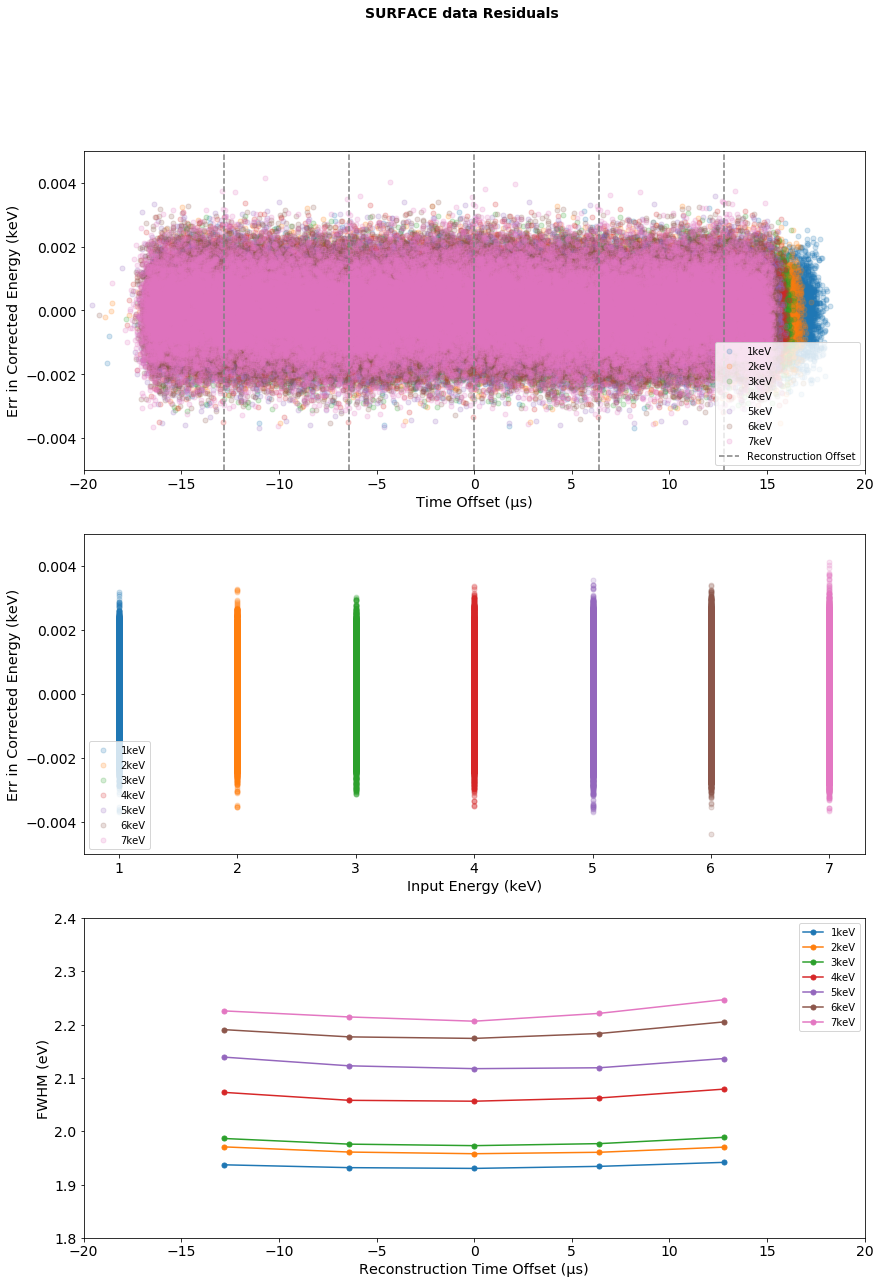

In [20]:
# RESIDUALS for SURFACE (2D plot): data used for surface and then corrected with coeffs (with UNCAL data)
# ================================
npts = nCpulses*len(errorT)
correctedE_SFC = np.zeros((len(test_keV),len(errorT), nCpulses))
fwhm_correctedE_SFC = np.zeros((len(test_keV),len(errorT)))
colors = list(mcolors.TABLEAU_COLORS)
errorT_float_us = tuple(float(s)/samprate*1e+6 for s in errorT)

fig = plt.figure(figsize=(14,20))
fig.suptitle('SURFACE data Residuals', fontsize=14, fontweight='bold')
yminmax = -0.005, 0.005 
ax = fig.add_subplot(3, 1, 1)
# plot correction residuals vs Time offset
for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    for j in range(0,len(errorT)):
        correctedE_SFC[i,j,] = np.polynomial.polynomial.polyval2d(ph_values[i,j,],diffTime_values_us[i,j,],coeffs)
        #points,= ax.plot(diffTime_values_us[i,j,], (correctedE_SFC[i,j,]- inkeV)/inkeV*100,
        #     marker='o', linestyle='', ms=5, color=colors[i])
        points,= ax.plot(diffTime_values_us[i,j,], (correctedE_SFC[i,j,]- inkeV),
             marker='o', linestyle='', ms=5, color=colors[i], alpha=0.2)
    points.set_label(str(test_keV[i])+'keV') 
# plot vertical lines for reconstruction offsets
for j in range(0,len(errorT)):
        vline = ax.axvline(errorT_float_us[j],linestyle='--', color='gray')
vline.set_label("Reconstruction Offset")
ax.legend()
ax.set_xlabel('Time Offset (μs)',fontsize='x-large')
ax.set_ylabel('Err in Corrected Energy (keV)', fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(yminmax)
ax.set_xlim(-20,20)

ax = fig.add_subplot(3, 1, 2)
# plot correction residuals vs Input Energy
for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    for j in range(0,len(errorT)):
        correctedE_SFC[i,j,] = np.polynomial.polynomial.polyval2d(ph_values[i,j,],diffTime_values_us[i,j,],coeffs)
        #points,= ax.plot(diffTime_values_us[i,j,], (correctedE_SFC[i,j,]- inkeV)/inkeV*100,
        #     marker='o', linestyle='', ms=5, color=colors[i])
        points,= ax.plot([inkeV]*nCpulses, (correctedE_SFC[i,j,]- inkeV),
             marker='o', linestyle='', ms=5, color=colors[i], alpha=0.2)
    points.set_label(str(test_keV[i])+'keV') 
ax.legend()
ax.set_xlabel('Input Energy (keV)',fontsize='x-large')
ax.set_ylabel('Err in Corrected Energy (keV)', fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(yminmax)



ax = fig.add_subplot(3, 1, 3)
# plot correction residuals
for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    for j in range(0,len(errorT)):
        fwhm_correctedE_SFC[i,j] = 2.35*np.std(correctedE_SFC[i,j,])*1000. # eV
    ax.plot(errorT_float_us, fwhm_correctedE_SFC[i,],
             marker='o', linestyle='-', ms=5, color=colors[i], label=str(test_keV[i])+'keV')
ax.legend()
ax.set_xlabel('Reconstruction Time Offset (μs)', fontsize='x-large')
ax.set_ylabel('FWHM (eV)', fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(1.8,2.4)
ax.set_xlim(-20,20)

fileplot = ("SFCresiduals_degPH" + str(degPH) + "_degTI" + str(degTI) + ".png")
fig.savefig(fileplot, dpi=fig.dpi)


# Test files energy corrections

Use uncalibrated test files to correct their energy based on the surface coefficients.

$\Delta$t is the offset between trigger Time and External Time info

Plot RSS

In [21]:
# Calculate FWHM of corrected energies
# ========================================
print("Correcting energies for ", TSpulses, "pulses with bbfb=", bbfb, "and samprate=",samprate, "Lc=", LcStr,
      " and NO lags")
# To know the minimim number of pulses of the set of different energies
npls_test = list()
for i in range(0,len(test_keV)):
    print ("Opening file ",test_evtFs[i])
    uncal = fits.open(test_evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    #print(uncalTab.size)
    npls_test.append(uncalTab.size)
    uncal.close()
nCpulses_test = np.amin(npls_test)
#nCpulses_test = 2000
print("nCpulses_test = ",nCpulses_test)

# Initialize arrays
time_values_test = np.zeros((len(test_keV),nCpulses_test)) 
#exttime_values_test = np.zeros((len(test_keV),len(timeErrorsStr),nCpulses_test)) 
ph_values_test = np.zeros((len(test_keV),len(timeErrorsStr), nCpulses_test)) 
diffTime_values_test_us = np.zeros((len(test_keV),len(timeErrorsStr),nCpulses_test)) 
clsidx_test = np.zeros((len(eners_keV),nCpulses_test)).astype(int)
corrE = np.zeros((len(test_keV),len(timeErrorsStr),nCpulses_test)) 

fwhmCorr = np.zeros((len(test_keV),len(timeErrorsStr))) 
fwhmCorr_err = np.zeros((len(test_keV),len(timeErrorsStr))) 
fwhmCorrStr = np.chararray((len(test_keV),len(timeErrorsStr)))
Rss = np.zeros((len(test_keV),len(timeErrorsStr)))
sRss = np.zeros((len(test_keV),len(timeErrorsStr)))

for i in range(0,len(test_keV)):
    # Detected uncal events
    #print ("Opening evt file ",test_evtFs[i])    
    uncal = fits.open(test_evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    uncalTimes = uncalTab['TIME'][0:nCpulses_test]
    uncalEners = uncalTab['SIGNAL'][0:nCpulses_test]
    uncal.close()
    
    # identify closest impact using sigma=0 impact file
    #print ("    Opening piximpact file ",test_impFs[i])    
    impFile = test_impFs[i] # test original impact file 
    imp = fits.open(impFile, memmap=True)
    impTab = imp[1].data
    impTimes = impTab['TIME']
    imp.close()
    ind = 0
    for k in range(0,nCpulses_test):
        clsidx_test[i,k] = int(find_nearest_idx(impTimes, uncalTimes[k]))
        diff = math.fabs(impTimes[clsidx_test[i,k]] - uncalTimes[k]) #secs
        if (diff > (numlags/samprate)): 
            print("No ctpart for photon ", k, "in file", evtFs[i][indexT0])
            print("Evt Time=",uncalTimes[k]," Closest impact time=", impTimes[clsidx[i,k]])
            raise RuntimeError  

    # assign ph_value_test and time differences for each photon in the reconstructed test file
    time_values_test[i,] = uncalTimes # same time_values for all sigmas impact files (time of reconstruction)
    for j in range(0,len(timeErrorsStr)):
        # Impacts
        if (float(timeErrorsStr[j]) != 0):
            impFile = test_impFs[i] + '.' + timeErrorsStr[j]
        else:
            impFile = test_impFs[i]
        #print ("    Opening piximpact file ",impFile)    
        imp = fits.open(impFile, memmap=True)
        impTab = imp[1].data
        impTimes = impTab['TIME']
        imp.close()
        ph_values_test[i,j,] = uncalEners
        for k in range(0,nCpulses_test):
            diffTime_values_test_us[i,j,k] = (time_values_test[i,k] - impTimes[clsidx_test[i,k]]) * 1e6
        
        corrE[i,j,] = np.polynomial.polynomial.polyval2d(ph_values_test[i,j,], diffTime_values_test_us[i,j,],coeffs)
        #print("[i,",j,",0]=> PH=", ph_values_test[i,j,0], "offset=",diffTime_values_test_us[i,j,0],"corrE=",corrE[i,j,0])
        
        fwhmCorr[i,j] = 2.35*np.std(corrE[i,j,])*1000. # eV
        fwhmCorr_err[i,j] = fwhmCorr[i,j]/np.sqrt(2*float(nCpulses_test)-2)
        fwhmCorrStr[i,j] = 'FWHM={:0.3f}+/-{:0.3f} eV'.format(fwhmCorr[i,j], fwhmCorr_err[i,j])
        Rss [i,j] =np.sqrt(fwhmCorr[i,j]**2-fwhmCorr[i,0]**2)
        sRss [i,j] = (1/Rss[i,j])*np.sqrt((fwhmCorr[i,j]**2)*(fwhmCorr_err[i,j]**2)+(fwhmCorr[i,0]**2)*(fwhmCorr_err[i,0]**2))
                

Correcting energies for  10000 pulses with bbfb= bbfb and samprate= 156250.0 Lc=   and NO lags
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep40000sam_10000p_SIRENA8192_pL8192_1keV_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb_FT3_NOlags.fits
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep40000sam_10000p_SIRENA8192_pL8192_2keV_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb_FT3_NOlags.fits
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep40000sam_10000p_SIRENA8192_pL8192_3keV_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb_FT3_NOlags.fits
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep40000sam_10000p_SIRENA8192_pL8192_4keV_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb_FT3_NOlags.fits
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep40000sam_10000p_SIRENA8192_pL8192_5keV_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb_FT3_NOlags.

/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars
/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in sqrt


Negative RSS values for E=1 keV
FWHM, FWHM_ERR= 1.9301222495258683 0.013637800793749882
FWHM0,FWHM0_ERR= 1.9302033258880744 0.013638373660715755
 (Z)Test statistic (standard score)=> 0.005944848486099774 SE

 p-value= 0.5000167575445044 

FWHM, FWHM_ERR= 1.9299262294474053 0.013636415760867996
FWHM0,FWHM0_ERR= 1.9302033258880744 0.013638373660715755
 (Z)Test statistic (standard score)=> 0.020318869296186776 SE

 p-value= 0.5000572755312832 



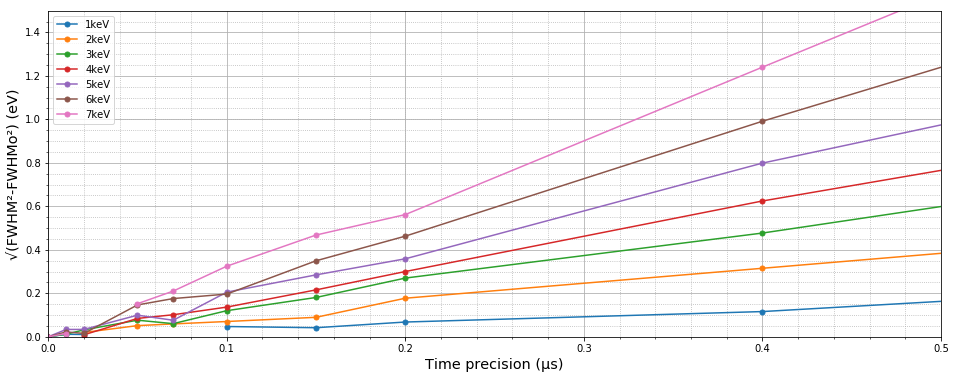

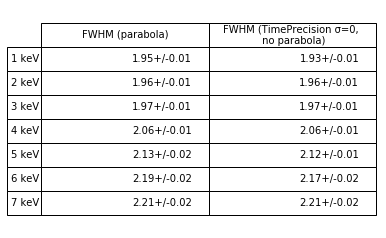

In [26]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 1, 1)

for i in range(0,len(test_keV)):
    #print(np.max(fwhmCorr[i,]))
    #plt.rc('grid', linestyle="--", color='gainsboro')
    #plt.errorbar([tus for tus in timeErrors_usec],Rss[i,],yerr=sRss[i,], marker='o', linestyle='solid', ms=5,label=str(test_keV[i])+'keV')
    #plt.plot(timeErrors_usec,Rss[i,], marker='o', linestyle='solid', ms=5,label=str(test_keV[i])+'keV')
    ax.plot(timeErrors_usec,Rss[i,], marker='o', linestyle='solid', ms=5,label=str(test_keV[i])+'keV')
    ax.minorticks_on()
    # for 1keV print FWHM and significance of negative difference
    if i == 0: 
        print("Negative RSS values for E=1 keV")
        for j in range(0,len(fwhmCorr[i,])):
            if (fwhmCorr[i,j] - fwhmCorr[i,0]) < 0:
                f1 = fwhmCorr[i,j]
                f1_err = fwhmCorr_err[i,j]
                f0 = fwhmCorr[i,0]
                f0_err = fwhmCorr_err[i,0]
                print("FWHM, FWHM_ERR=",f1, f1_err)
                print("FWHM0,FWHM0_ERR=",f0, f0_err)
                stat_f1_f0 = abs(f1-f0)/mean([f1_err,f0_err])
                print(" (Z)Test statistic (standard score)=>",stat_f1_f0,"SE\n")
                val1 = max(f1,f0)
                val2 = min(f1,f0)
                mn = mean([f1,f0])
                #pvalue<-sprintf("%.4f",pnorm(val1,val2,mn,lower.tail = FALSE))
                pvalue = norm.cdf(val1,val2,mn)
                print(" p-value=",pvalue,"\n")

        
        
    ax.set_ylabel("\u221A(FWHM²-FWHMo²) (eV)", fontsize='x-large')
    #plt.errorbar([k*1e6 for k in timeErrors],fwhmCorr[i,],yerr=fwhmCorr_err[i,], marker='o', linestyle='none', ms=2,label=str(test_keV[i])+'keV')
    ax.set_xlabel("Time precision (μs)", fontsize='x-large')
    ax.legend()
    ax.grid(which='minor', linestyle=':')
    #plt.yscale('log')
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,1.5)
    
plt.grid(b=True)
plt.show()
fileplot = (("FWHMvsClockerror_ikeV_" + str(TSpulses) + ".png"))
fig.savefig(fileplot, dpi=fig.dpi)

    
# Plot table with FWHM comparison
#===================================
# read FWHM for calibrated (1D), lags=1, normal optimal filtering to compare
import json
fwhmCorr_Best = []
fwhmCorr_err_Best = []
for i in range(0,len(test_keV)):
    eresolFile = (ereDir + "/eresol_" + str(TSpulses) +
            "p_SIRENA" + str(nSamples)+ "_pL" + str(pulseLength) + "_" + str(test_keV[i]) +
            "keV_STC_" + domain + "_fixedlib6OF_" + recStr + str(pulseLength) + smprtStr + jitterStr +
            bbfbStr + LcStr + ".json1D")
    
    with open(eresolFile) as json_file:
        data = json.load(json_file)
        for p in data :
            fwhmCorr_Best.append(p['fwhmEreal']['all']) 
            fwhmCorr_err_Best.append(p['fwhmEreal_err']['all']) 
params = {'mathtext.default': 'regular' }
#col_labels=["$FWHM_{LAGS}$","$FWHM_{NOLAGS0}$"]
col_labels=["FWHM (parabola)","FWHM (TimePrecision σ=0, \n no parabola)"]
row_labels = []
table_vals = []
for i in range(0,len(test_keV)):
    #row_labels.append(str(i+1) + " keV")
    row_labels.append(str(test_keV[i]) + " keV")
    newrow_best = '{:0.2f}+/-{:0.2f}'.format(float(fwhmCorr_Best[i]), float(fwhmCorr_err_Best[i]))
    newrow_sigma0 = '{:0.2f}+/-{:0.2f}'.format(fwhmCorr[i,0], fwhmCorr_err[i,0])
    table_vals.append([newrow_best, newrow_sigma0])
    #table_vals.append([fwhmCorr_Best[i],round(fwhmCorr[i,0],5)])

#the rectangle is where I want to place the table
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.25]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(2, 2)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
    




In [ ]:
# RESIDUALS for TEST DATA (2D plot): data test corrected with coeffs 
# ================================
npts = nCpulses_test*len(timeErrorsStr)
fig = plt.figure(figsize=(16,6))
fig.suptitle('TEST data Residuals', fontsize=14, fontweight='bold')
correctedE = np.zeros((len(test_keV),npts))

for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    correctedE[i,] = np.polynomial.polynomial.polyval2d(ph_values_test[i,],diffTime_values_test[i,],coeffs)
    plt.plot(1e6*diffTime_values_test[i,], (correctedE[i,]- inkeV)/inkeV*100,
             marker='o', linestyle='', ms=5,label=str(test_keV[i])+'keV')
    plt.legend()
plt.xlabel('Time Offset (μs)')
plt.ylabel('Relative Err in Corrected Energy (%)')



In [ ]:
print(ph_values.shape)
print(ph_values_test.shape)

print("ph_values[6,0],ph_values[6,10016],ph_values[6,20032]")
print(ph_values[6,0],ph_values[6,10016],ph_values[6,20032])
print("ph_values_test[7,0]")
print(ph_values_test[6,0])

In [ ]:
# PLOT CORRECTION RESIDUALS of test files (same as those for the time plot)
fig = plt.figure(figsize=(16,6))
fig.suptitle('Correction Residuals', fontsize=14, fontweight='bold')
# At (us) =  timeDetected-timePiximpact
plt.xlabel('Time Offset (μs)')
plt.ylabel('Corrected Energy Residuals (%)')
plt.ylim(-0.4,0.4)
for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    plt.plot(1e6*diffTime_values_test[i,], (corrE[i,]- inkeV)/inkeV*100,
             marker='o', linestyle='', ms=5,label=str(test_keV[i])+'keV')
    plt.legend()
plt.show()

#plot corrected energy@7keV
fig = plt.figure(figsize=(16,6))
fig.suptitle('Correction @7keV', fontsize=14, fontweight='bold')
plt.xlabel('Time Offset (μs)')
plt.ylabel('Corrected Energy (keV)')
inkeV = eners_keV[6]
#for j in range(0,len(timeErrors)):
for j in [0,5,10]:
    plt.plot(1e6*diffTime_values_test[6,j*nCpulses_test:(j+1)*nCpulses_test], 
             corrE[6,j*nCpulses_test:(j+1)*nCpulses_test],
             marker='o', linestyle='', ms=5,label=('{:.2f}'.format(timeErrors_usec[j])+"(μs)"))
plt.legend()
plt.show()

# plot only corrected photons for clock=0
fig = plt.figure(figsize=(6,6))
fig.suptitle('Perfect clock', fontsize=14, fontweight='bold')
for i in range(0,len(eners_keV)):
    inkeV = eners_keV[i]
    plt.plot(1e6*diffTime_values_test[i,0:nCpulses_test], (corrE[i,0:nCpulses_test]- inkeV)/inkeV*100,
        marker='o', linestyle='', ms=5,label=str(test_keV[i])+'keV')
fwhmCorr[5,0] = 2.35*np.std(corrE[5,0:nCpulses_test])*1000. # eV
plt.xlabel('Time Offset (μs)')
plt.ylabel('(Ecorr-Einput)/Einput (%)')
plt.legend()
plt.xlim(-5,5)
plt.show()
print("FWHM0[6keV]]=",fwhmCorr[5,0])

In [ ]:
# Plot 3D residuals
plot=0
if plot:
    # PLOT INITIAL DATA & RESIDUALS
    X = np.zeros((len(eners_keV), npts))
    Y = np.zeros((len(eners_keV), npts))
    # 1) DATA for SURFACE
    # -------------------
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('Test', fontsize=14, fontweight='bold')
    ax = fig.add_subplot(131, projection='3d')
    # At (us) =  timeDetected-timePiximpact
    ax.set_xlabel('Time Offset (μs)')
    ax.set_ylabel('Reconstructed PH (a.u.)')
    ax.set_zlabel('Input energy (keV)')
    for i in range(0,len(eners_keV)):
        X[i,] = diffTime_values[i,]*1e6
        Y[i,] = ph_values[i,]
        ax.scatter(xs=X[i,], ys=Y[i,], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)

    # 2) RECONSTRUCTED energies for surface input data 
    # ------------------------------------------------
    ax2 = fig.add_subplot(132, projection='3d')
    # At (us) =  timeDetected-timePiximpact
    ax2.set_xlabel('Time Offset (μs)')
    ax2.set_ylabel('Reconstructed PH (a.u.)')
    ax2.set_zlabel('Input energy (keV)')
    correctedE = np.zeros((len(test_keV),npts))
    for i in range(0,len(eners_keV)):
        X[i,] = diffTime_values[i,]
        Y[i,] = ph_values[i,]
        correctedE[i,] = np.polynomial.polynomial.polyval2d(ph_values[i,],diffTime_values[i,],coeffs)
        ax2.scatter(xs=X[i,]*1e6, ys=Y[i,], zs=correctedE[i,], zdir='z', s=20, c=cols[i], depthshade=True)

    # 3) RESIDUALS in input data (RECONSTRUCTED - input_simulated)
    # --------------------------------------------------------------
    ax3 = fig.add_subplot(133, projection='3d')
    # At (us) =  timeDetected-timePiximpact
    ax3.set_xlabel('Time Offset (μs)')
    ax3.set_ylabel('Reconstructed PH (a.u.)')
    ax3.set_zlabel('Residuals(InputE-CorrE) (eV)')
    ax3.set_xlim([-20,20])
    for i in range(0,len(eners_keV)):
        X[i,] = diffTime_values[i,]
        Y[i,] = ph_values[i,]
        ax3.scatter(xs=X[i,]*1e6, ys=Y[i,], zs=(eners_keV[i]-correctedE[i,])*1e3, zdir='z', s=20, 
                    c=cols[i], depthshade=True)
    print("CorrE(7keV,1500)=", correctedE[6,1500])

In [ ]:
# checking section
print(nCpulses_test)
print(len(errorT))
#time_values = np.zeros((len(eners_keV),nCpulses*len(errorT))) 

print(len(diffTime_values_test[1,]))
print(len(timeErrorsStr))